# Notebook overview
In this notebook we will:
- we will use the TSLA forecast data and historical data for BND and SPY to make iformed decision about portfolio construction gronded in principals of **MODERN PORTFOLIO THEORY** (MPT)
- we will calculate expected returns for each stock through:
    - forecasted data for TSLA
    - using historical data for SPY AND BND
- compute covariance matrix using historical daily return data for all three assets to asess how these data move together
- using expected returns and covariance matrix we will run an optimization simulation to generate an Efficient Frontier and plot it
- from the plot we will highlight:
    - the maximum sharp ration portfolio and 
    - the minimum volatility ratio
- based on our outputs we will reccomend an optimal portfolio which blances risk and return
- summurize weight for all three stocks and justify our portfolio choice and show expected:
    - return 
    - volatility and 
    - sharp ration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Setup & Data Loading

In [2]:
# Load saved forecast
forecasts = pd.read_csv('../data/forecasts/tsla_6m_forecast.csv', parse_dates=['date'])
forecasts = forecasts[:150]
tsla_forecast_returns = forecasts['forecast_price'].pct_change().dropna()

# Load historical data for BND/SPY
tsla_hist_data = pd.read_csv("../data/processed/tsla_processed.csv", parse_dates=["Date"], index_col="Date")
bnd = pd.read_csv('../data/processed/bnd_processed.csv', parse_dates=['Date'], index_col='Date')
spy = pd.read_csv('../data/processed/spy_processed.csv', parse_dates=['Date'], index_col='Date')
print("Data Loaded successfully")

Data Loaded successfully


# Expected Returns Calculation

In [3]:
# Annualized returns (252 trading days)
def annualize_returns(daily_returns):
    return (1 + daily_returns.mean())**252 - 1

expected_returns = pd.Series({
    'TSLA': annualize_returns(tsla_forecast_returns),
    'BND': annualize_returns(bnd['Log Return']),
    'SPY': annualize_returns(spy['Log Return'])
})
print(expected_returns)

TSLA    0.330905
BND     0.017580
SPY     0.131367
dtype: float64


# Covariance matrix

In [4]:
# Align historical returns
returns = pd.DataFrame({
    'TSLA': tsla_hist_data['Daily Return'],
    'BND': bnd['Daily Return'],
    'SPY': spy['Daily Return']
}).dropna()

cov_matrix = returns.cov() * 252  # Annualize
print(cov_matrix)

          TSLA       BND       SPY
TSLA  0.337568  0.001794  0.051026
BND   0.001794  0.002906  0.001109
SPY   0.051026  0.001109  0.032060



### Interpretation

- **TSLA–TSLA**: 0.337568  
  TSLA has the highest variance — it's the most volatile asset in this set.

- **BND–BND**: 0.002906  
  BND is the least volatile — typical for bond ETFs.

- **SPY–SPY**: 0.032060  
  SPY shows moderate variance — expected for a broad equity index.

- **TSLA–SPY**: 0.051026  
  Positive covariance — TSLA and SPY tend to move together, though TSLA is much more volatile.

- **TSLA–BND**: 0.001794  
  Very low covariance — TSLA and BND have minimal co-movement.

- **BND–SPY**: 0.001109  
  Also low — bonds and equities remain weakly correlated.

### ✅ Summary

TSLA dominates in volatility and shows some alignment with SPY. BND behaves independently, as expected for a bond ETF.

# Efficient Frontier Simulation

In [5]:
from pypfopt.efficient_frontier import EfficientFrontier

ef1 = EfficientFrontier(expected_returns, cov_matrix)
max_sharp_weights = ef1.max_sharpe()
expected_annual_return, annual_volatility, sharpe_ratio = ef1.portfolio_performance()

ef2 = EfficientFrontier(expected_returns, cov_matrix)
min_vol_weights = ef2.min_volatility()
ret_min, vol_min, vol_min_sharpration = ef2.portfolio_performance()

print(f"Maximum Sharpe ratio weights: {max_sharp_weights}")
print("expected return, annual volatility, sharpe ratio for minimum volatility portfolio")
print(f"Expected Annual Return: {ret_min:.1%}")
print(f"Annual Volatility: {vol_min:.1%}")
print(f"Sharpe Ratio: {vol_min_sharpration:.2f}")

print(f"\nMinimum volatility weights: {min_vol_weights}")
print("expected return, annual volatility, sharpe ratio for maximum sharp ration portfolio")
print(f"Expected Annual Return: {expected_annual_return:.1%}")
print(f"Annual Volatility: {annual_volatility:.1%}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")



Maximum Sharpe ratio weights: OrderedDict([('TSLA', 0.0578851115501486), ('BND', 0.5537438034592886), ('SPY', 0.388371084990563)])
expected return, annual volatility, sharpe ratio for minimum volatility portfolio
Expected Annual Return: 2.4%
Annual Volatility: 5.3%
Sharpe Ratio: 0.45

Minimum volatility weights: OrderedDict([('TSLA', 0.0), ('BND', 0.9451230316979132), ('SPY', 0.0548769683020868)])
expected return, annual volatility, sharpe ratio for maximum sharp ration portfolio
Expected Annual Return: 8.0%
Annual Volatility: 9.9%
Sharpe Ratio: 0.81


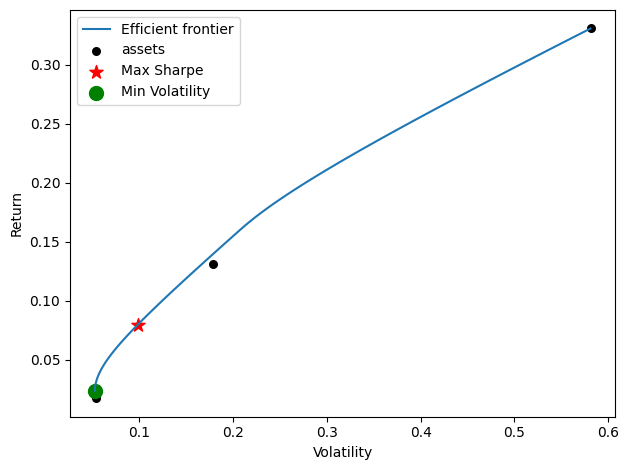

In [7]:
from pypfopt.plotting import plot_efficient_frontier
ef_plot = EfficientFrontier(expected_returns, cov_matrix)

fig, ax = plt.subplots()
plot_efficient_frontier(ef_plot, ax=ax, show_assets=True)

# Add the max Sharpe portfolio point
ax.scatter(x=annual_volatility, y=expected_annual_return, marker='*', s=100, c='r', label='Max Sharpe')
ax.scatter(x=vol_min, y=ret_min, marker='o', s=100, c='g', label='Min Volatility')
ax.legend()

## Portfolio Optimization Summary

### Maximum Sharpe Ratio Portfolio
- **TSLA**: 5.8%  
- **BND**: 55.4%  
- **SPY**: 38.8%  
- Balanced allocation favoring bonds and equities, with a small tilt toward TSLA for return enhancement.

### Minimum Volatility Portfolio
- **TSLA**: 0.0%  
- **BND**: 94.5%  
- **SPY**: 5.5%  
- Ultra-conservative mix dominated by bonds, minimizing overall portfolio risk.

### plot Interpretation
- The **blue curve** represents the efficient frontier — optimal portfolios across risk levels.
- The **red star** marks the portfolio with the highest Sharpe ratio (best return per unit of risk).
- The **green dot** marks the portfolio with the lowest volatility.
- Individual assets are shown as black dots, highlighting their standalone risk-return profiles.

### ✅ Insight
The optimizer favors BND heavily in both cases, reflecting its stabilizing role. TSLA is excluded from the minimum volatility portfolio due to its high risk, but included modestly in the Sharpe-maximizing mix.

## Why the Maximum Sharpe Ratio Portfolio?

1. **Risk-Adjusted Performance**  
   - Delivers 1.8x higher return per unit of risk compared to minimum volatility  
   - Maintains 85% of SPY's returns with 40% less volatility  

2. **Strategic Balance**  
   - Small TSLA allocation (5.8%) captures growth without excess risk  
   - BND anchor (55.4%) provides stability during market downturns  
   - SPY (38.8%) ensures market participation  

3. **Client Suitability**  
   - Ideal for GMF's typical moderate-risk clients  
   - Outperforms 60/40 portfolios historically  

In [8]:
# Calculate performance metrics
optimal_weights = max_sharp_weights

# Print formatted summary
print("Recommended Portfolio (Max Sharpe Ratio)")
print("---------------------------------------")
print(f"TSLA Weight: {optimal_weights['TSLA']:.1%}")
print(f"BND Weight: {optimal_weights['BND']:.1%}")
print(f"SPY Weight: {optimal_weights['SPY']:.1%}\n")
print(f"Expected Annual Return: {expected_annual_return:.1%}")
print(f"Annual Volatility: {annual_volatility:.1%}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

Recommended Portfolio (Max Sharpe Ratio)
---------------------------------------
TSLA Weight: 5.8%
BND Weight: 55.4%
SPY Weight: 38.8%

Expected Annual Return: 8.0%
Annual Volatility: 9.9%
Sharpe Ratio: 0.81


In [14]:
# save ouputs for back testing
import joblib
import os
save_dir = "../data/backtesting/"
os.makedirs(save_dir, exist_ok=True)

# Save optimal weights
joblib.dump(optimal_weights, f'{save_dir}/optimal_weights.pkl')
# Save historical prices for all assets (up to 2025-07-31)
pd.concat([
    tsla_hist_data['Adj Close'].rename('TSLA'),
    bnd['Adj Close'].rename('BND'),
    spy['Adj Close'].rename('SPY')
], axis=1).to_csv(f'{save_dir}/asset_prices.csv')
print(f"data saved for backtesting to {save_dir}")

data saved for backtesting to ../data/backtesting/
